
**참고자료**
<br>
<br>
 * https://somjang.tistory.com/entry/Keras%EA%B8%B0%EC%82%AC-%EC%A0%9C%EB%AA%A9%EC%9D%84-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B8%8D%EC%A0%95-%EB%B6%80%EC%A0%95-%EC%A4%91%EB%A6%BD-%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0
<br>
<br>
 * https://sig413.tistory.com/5
<br>
<br>
 * https://www.youtube.com/watch?v=7GUoDHxN5NM

# 네이버 기사 감정 분석

## 데이터 불러오기
<br>

**데이터 특성 정의( 각각의 데이터가 어떤 특성을 가지는지? )**

    ▶ date : 등록된 기사별 날짜
    ▶ title : 기사 제목
    ▶ source : 언론사
    ▶ contents : 기사 내용 요약본
    ▶ link : 사이트 주소

※ : 네이버 뉴스 기준으로 Test... ( 구글 뉴스데이터와 병합해서 전처리 실시 예정 )

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime, time
import re
import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 시각화 글자 깨짐 방지
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
matplotlib.rc('font',family='NanumGothic')

# 한글 폰트 적용
matplotlib.rc('axes', unicode_minus = False) # True

# 2022 / 04 / 21 일자 스크래핑 데이터
# df_news = pd.read_csv('./news_data.csv', engine= 'python',encoding = 'utf-8')
df_news = pd.read_csv('./news_data(Raw_Data 2021.05.01 ~ 2022.05.01 검색어-DGB대구은행).csv', engine= 'python',encoding = 'utf-8')

# (행, 열)
print(df_news.shape)
df_news.head(1)

(12867, 12)


,Unnamed: 0,date,title,source,contents,link,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,http://www.g-enews.com/ko-kr/news/article/news...,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 데이터 구조 파악시 용이
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   12867 non-null  int64 
 1   date         12867 non-null  object
 2   title        12867 non-null  object
 3   source       12867 non-null  object
 4   contents     12864 non-null  object
 5   link         12867 non-null  object
 6   Unnamed: 6   108 non-null    object
 7   Unnamed: 7   65 non-null     object
 8   Unnamed: 8   14 non-null     object
 9   Unnamed: 9   14 non-null     object
 10  Unnamed: 10  6 non-null      object
 11  Unnamed: 11  5 non-null      object
dtypes: int64(1), object(11)
memory usage: 1.2+ MB


# 데이터 전처리

## 이상치와 결측치 제거 / 데이터 특성(구조) 확인
    ▶ 필요없는 컬럼 제거
    ▶ 컬럼명과 순서 변경 
    ▶ 데이터 구조 파악 - info, head
    
    ▶ 우선 'DGB대구은행'과 필요없는 언론사는 버리고 인덱스번호도 초기화 시켜야 함.
    예를 들면, 축구관련 기사

    제목과 요약본 기준
    '감독' / '신태용' / 'DGB대구은행파크' / '대표팀' / '경기' / '스포츠' / '축구'
    참고 사이트 : https://jimmy-ai.tistory.com/92
※ : 수치별 데이터가 아니므로 이상치는 굳이 확인할 필요가 없다고 판단

In [5]:
# 필요한 데이터만 추출 / 컬럼명 변경
df_news = df_news.loc[:,['date', 'title', 'source', 'contents']]
df_news.rename(columns={'source' : 'press'}, inplace=True)

In [6]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      12867 non-null  object
 1   title     12867 non-null  object
 2   press     12867 non-null  object
 3   contents  12864 non-null  object
dtypes: object(4)
memory usage: 402.2+ KB


In [7]:
df_news.head(1)

,date,title,press,contents
0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...


In [8]:
# 행별로 null값 존재 유무 파악 --> 결측치 contents쪽에 3개 존재.
df_news.isnull().sum(axis = 0)

date        0
title       0
press       0
contents    3
dtype: int64

In [9]:
df_news[df_news['contents'].str.contains('오류', na=False)][:5]

,date,title,press,contents
3217,2021.08.04.,검찰 '캄보디아 부동산 계약 사고' 관련 대구은행 압수수색,뉴스1,오류:509
3218,2021.08.04.,검찰 '캄보디아 부동산 계약 사고' 관련 대구은행 압수수색,뉴스1,오류:509
3219,2021.08.04.,검찰 '캄보디아 부동산 계약 사고' 관련 대구은행 압수수색,뉴스1,오류:509
3226,2021.08.04.,"검찰, 대구은행 압수수색..캄보디아 부동산 매입 손실 사건",뉴스1,오류:509
3227,2021.08.04.,"검찰, 대구은행 압수수색..캄보디아 부동산 매입 손실 사건",뉴스1,오류:509


In [10]:
# 불필요한 내용 삭제 / contents의 길이가 20이하 또는 title의 길이가 10 이하인 데이터
df_news.head()

# 51개 스크래핑 오류

print('이상치 제거 전:',len(df_news[df_news['contents'].str.contains('오류', na=False)]))

for i in df_news[df_news['contents'].str.contains('오류', na=False)].index:
    df_news.drop(i, axis=0, inplace=True)
    
print('이상치 제거 후:',len(df_news[df_news['contents'].str.contains('오류', na=False)]))

이상치 제거 전: 51
이상치 제거 후: 0


In [11]:
df_news.head(1)

,date,title,press,contents
0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...


In [12]:
# 중복행 제거 --> 분석하는데 안 좋을 수도 있으니 신중한 고려가 필요함.
# 참고 : https://sy-log.tistory.com/60

print(df_news.shape)
print('중복행 제거 전 데이터 :', len(df_news))
# 중복행 살림.
print('중복행 갯수 : %d개' % df_news.duplicated().sum())
print('중복행 제거 후 데이터 :', len(df_news.drop_duplicates(['title'], keep = False)))

(12816, 4)
중복행 제거 전 데이터 : 12816
중복행 갯수 : 165개
중복행 제거 후 데이터 : 10691


In [13]:
# 중복 제거 일부러 하지 않음.
len(df_news)

12816

In [14]:
# AND용
# target_string = ['서울', '마포']
# df[df['주소'].map(lambda x: all(string in x for string in target_string))]
# df_news.head()

In [15]:
len(df_news)

12816

In [16]:
# df.query('주소.str.contains("마포|은평")', engine='python'
# Series 내장함수 : str.contains() 

# 제목
remove_title = list(df_news.query('title.str.contains("부상|선수|승점|구장|리그|DGB대구은행파크|FC|감독|신태용|연승|대표팀|친선경기|스포츠|축구|세징야", na=False)', engine = 'python').index)
df_news.drop(remove_title, axis=0, inplace = True)

# 내용 요약본
remove_contents = list(df_news.query('contents.str.contains("부상|선수|승점|구장|리그|DGB대구은행파크|FC|감독|신태용|연승|대표팀|친선경기|스포츠|축구|세징야", na=False)', engine = 'python').index)
df_news.drop(remove_contents, axis=0, inplace = True)


### 결측치 처리 contents 컬럼에 3개 존재 --> 3개의 데이터 삭제

In [17]:
df_news.count()

date        9000
title       9000
press       9000
contents    8997
dtype: int64

In [18]:
print(df_news.isnull().sum())
df_news.dropna(axis=0, inplace = True)

date        0
title       0
press       0
contents    3
dtype: int64


In [19]:
df_news.shape

(8997, 4)

In [20]:
# 인덱스 번호 새로 부여.
df_news.reset_index(inplace=True)
df_news.drop(['index'], axis=1, inplace=True)

In [21]:
df_news.head()

,date,title,press,contents
0,2021.05.01.,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...
1,2021.05.01.,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",경북신문,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...
2,2021.05.01.,은행·비은행 동반성장…지방금융지주 1분기 '好好好',미디어펜,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다. 핵심 계열사인 대구은행...
3,2021.05.01.,"DGB대구銀, 코로나 대응 관련 ‘유공 행정안전부 장관표창’",더퍼블릭,DGB대구은행(이하 대구은행)은 코로나19 재난 방역 적극 참여 및 지역사회 지원활...
4,2021.05.01.,"대구은행, 방역취약계층 어르신 대상 KF94 마스크 전달",일요신문,"- DGB대구은행, 어버이날 맞아 효(孝) 마스크 지원 DGB대구은행(은행장 임성훈..."


In [22]:
df_news.count()

date        8997
title       8997
press       8997
contents    8997
dtype: int64

## 날짜 데이터 정제
    ▶ 연월일로만 표현 ( 시간 제거 )
    ▶ 연 / 월 / 일 3개의 파생변수 생성
    ▶ 연 / 일 보다는 월별로 각 언론사의 'DGB대구은행'에 관련된 기사가 얼마나 많은지? 파악하기 위함. --> 긍정 / 부정 개수로 이어짐.

In [23]:
# 연도별 월별 일별로 
df_news['date']

0       2021.05.01.
1       2021.05.01.
2       2021.05.01.
3       2021.05.01.
4       2021.05.01.
           ...     
8992           4일 전
8993           4일 전
8994           4일 전
8995           4일 전
8996           4일 전
Name: date, Length: 8997, dtype: object

In [24]:
now = time.localtime()

# 테스트 용 / 참고 - https://wikidocs.net/104836
print(datetime.datetime.now())
print('{}년 {}월 {}일'.format(now.tm_year, now.tm_mon, now.tm_mday-1))
print(pd.to_datetime(df_news['date'][0]) - datetime.timedelta(days = 6))

2022-05-19 17:10:47.572178
2022년 5월 18일
2021-04-25 00:00:00


In [25]:
# 2022-04-21 17:45 일자 데이터 자료 ( 시각은 무시 )
scrapping_date = datetime.date(2022, 5, 6)

idx_list = list()

for i in range(len(df_news['date'])):
    if '일' in df_news['date'][i]:
        idx_list.append(i)
    elif '시간' in df_news['date'][i]:
        idx_list.append(i)
# df_news['date'][i]
# 몇 일전 / 몇 시간전 인덱스 번호

In [26]:
# 확인
df_news.loc[idx_list, ['date']][:3]

,date
8872,7일 전
8873,7일 전
8874,7일 전


In [27]:
# 시간 전 / 몇일 전 --> 숫자로 변환

for i in idx_list:
    
    trans_day = int(re.findall('\d+', df_news['date'][i])[0]) 

    if '시간' in df_news['date'][i]:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=1)
    else:
        df_news['date'][i] = scrapping_date - datetime.timedelta(days=trans_day+1)

In [28]:
df_news['date'] = pd.to_datetime(df_news['date'])

In [29]:
df_news['year'] = df_news['date'].dt.year
df_news['month'] = df_news['date'].dt.month
df_news['day'] = df_news['date'].dt.day

In [30]:
df_news.head(1)

,date,title,press,contents,year,month,day
0,2021-05-01,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,2021,5,1


In [31]:
# 데이터 자료 시간에서 마이너스해주면 날짜가 나옴.
# 이것을 다시 대입해주면 날짜 데이터 정제 완료

# 컬럼 제거 axis = 1 --> 열 / axis = 0 --> 행
# df_news.drop(['date_day'], axis=1, inplace=True)

In [32]:
# 참고 : https://hogni.tistory.com/51
# 컬럼 순서 정렬
df_news = df_news[['date', 'year', 'month', 'day', 'title', 'press', 'contents']]

In [33]:
df_news.head(3)

,date,year,month,day,title,press,contents
0,2021-05-01,2021,5,1,"DGB대구은행, 은행권 중금리대출 실적 1위",글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...
1,2021-05-01,2021,5,1,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",경북신문,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...
2,2021-05-01,2021,5,1,은행·비은행 동반성장…지방금융지주 1분기 '好好好',미디어펜,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다. 핵심 계열사인 대구은행...


In [34]:
df_news.loc[:, ['date']].tail(3)

,date
8994,2022-05-01
8995,2022-05-01
8996,2022-05-01


## 정규식 표현 처리

<br>

'[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》]' 등을 기사제목에서 제거
- tqdm --> 진행률 표시 모듈

**※ 참고 : https://clolee.tistory.com/17, https://codingspooning.tistory.com/138**
<br>

### 정규식 표현 ( 기사 제목 )

In [35]:
from tqdm import tqdm
import copy

# 경고 off
pd.set_option('mode.chained_assignment', None)

# 원본 데이터프레임 복사하여 사용
df_news_copy = copy.deepcopy(df_news)
df_news_copy.insert(5, 'nouns_title', '0')
title_data = df_news_copy['title'].tolist()

# re.sub('[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》→p”“◇證‧]',
for i in range(len(title_data)):
    cleaner = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·◇②【】<>�→α&]', '', title_data[i])
    df_news_copy['nouns_title'][i] = cleaner

df_news_copy.loc[:5,['title', 'nouns_title']]

,title,nouns_title
0,"DGB대구은행, 은행권 중금리대출 실적 1위",DGB대구은행 은행권 중금리대출 실적 1위
1,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",DGB대구은행 어버이날 맞이 효孝 마스크 지원
2,은행·비은행 동반성장…지방금융지주 1분기 '好好好',은행비은행 동반성장지방금융지주 1분기 好好好
3,"DGB대구銀, 코로나 대응 관련 ‘유공 행정안전부 장관표창’",DGB대구銀 코로나 대응 관련 유공 행정안전부 장관표창
4,"대구은행, 방역취약계층 어르신 대상 KF94 마스크 전달",대구은행 방역취약계층 어르신 대상 KF94 마스크 전달
5,지방금융그룹도 1분기 사상최대 실적…비은행 계열 선전,지방금융그룹도 1분기 사상최대 실적비은행 계열 선전


### 정규식 표현 ( 기사 내용 )

In [36]:
from tqdm import tqdm
import copy

# 경고 off
pd.set_option('mode.chained_assignment', None)

# 원본 데이터프레임 복사하여 사용
df_news_copy = copy.deepcopy(df_news_copy)
df_news_copy.insert(8, 'nouns_contents', '0')
contents_data = df_news_copy['contents'].tolist()

# re.sub('[-=+,#/\?:^$.@*\"※%~&ㆍ\‘\’\_, ②外∙·!』『\(\)\[\]\[\]\<\>\'\`<\>\銀…\"\'…》→p”“◇證‧]',
for i in range(len(contents_data)):
    cleaner = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·◇②【】<>�→α&]', '', contents_data[i])
    df_news_copy['nouns_contents'][i] = cleaner

df_news_copy.loc[:5,['contents', 'nouns_contents']]

,contents,nouns_contents
0,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...
1,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...,DGB대구은행은행장 임성훈은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르신들...
2,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다. 핵심 계열사인 대구은행...,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다 핵심 계열사인 대구은행은...
3,DGB대구은행(이하 대구은행)은 코로나19 재난 방역 적극 참여 및 지역사회 지원활...,DGB대구은행이하 대구은행은 코로나19 재난 방역 적극 참여 및 지역사회 지원활동을...
4,"- DGB대구은행, 어버이날 맞아 효(孝) 마스크 지원 DGB대구은행(은행장 임성훈...",DGB대구은행 어버이날 맞아 효孝 마스크 지원 DGB대구은행은행장 임성훈이 어버이...
5,"시장금리 상승세에 힘입어 대구은행의 순이자마진이 회복한 데 이어, 비은행 계열인 하...",시장금리 상승세에 힘입어 대구은행의 순이자마진이 회복한 데 이어 비은행 계열인 하이...


## 토큰화 및 불용어 제거( 1차 )

<br>

**Hannanum / Kkma / Komoran / Mecab / Twitter(Okt, 사용?)**
- 제목을 토큰화 시킴
- Okt형태소 분석기 사용
- norm = True --> 문장을 정규화 Ex) 늘린, 늘린 / 문장 그대로
- stem = True --> 문장을 정규화 Ex) 늘린, 늘리다 / 줄인, 줄이다 / 예뻐서 예뻤다, 예쁘다 / 즉, stem을 사용해야 함. 
- (stem은 stemming 어간화라는 뜻)
<br>

**불용어 : 자연어 처리에 큰 영향을 주지 않는 중요하지 않은 단어들을 말합니다. 주로 조사나 접사 등이 불용어**

In [37]:
import konlpy
from konlpy.tag import Okt
okt = Okt()

In [38]:
# 테스트
print(okt.morphs('늘린 결과이다 줄인 많아서 예뻤다 1위', norm=True))
print(okt.morphs('늘린 결과이다 줄인 많아서 예뻐서 1위', stem=True))

['늘린', '결과', '이다', '줄인', '많아서', '예뻤다', '1', '위']
['늘리다', '결과', '이다', '줄이다', '많다', '예쁘다', '1', '위']


In [39]:
stopwords = ['의', '가', '이', '은', '는', '좀',
             '잘', '걍', '과', '도', '를', '자',
             '으로', '에', '와', '한', '하다']

In [40]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
for sentence in df_news_copy['nouns_title']:
    tmp_X = okt.morphs(sentence, stem=True) # 토큰화
    tmp_X = [word for word in tmp_X if not word in stopwords] # 불용어 제거  
#     print('예외처리 전 :', tmp_X)

    # ['1', '위'] --> ['1위'] 붙이기
    if ('1' in tmp_X) and ('위' in tmp_X):
        for i in range(len(tmp_X)):
            if tmp_X[i] == '위' and tmp_X[i-1] == '1':
                tmp_X[i-1] += tmp_X.pop(i)
                break
    copy_tmp = tmp_X.copy()
    df_news_copy.replace({'nouns_title':sentence}, ' '.join(copy_tmp), inplace=True) # 공백 기준으로 단어 나누기.

In [41]:
df_news_copy.loc[:3, ['title', 'nouns_title']]

,title,nouns_title
0,"DGB대구은행, 은행권 중금리대출 실적 1위",DGB 대구 은행 은행권 중 금리 대출 실적 1위
1,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",DGB 대구 은행 어버이날 맞이 효 孝 마스크 지원
2,은행·비은행 동반성장…지방금융지주 1분기 '好好好',은행 비 은행 동반성 장 지방 금융 지주 1분 기 好好好
3,"DGB대구銀, 코로나 대응 관련 ‘유공 행정안전부 장관표창’",DGB 대구 銀 코로나 대응 관련 유공 행정안전부 장관 표창


In [42]:
# 테스트테스트

In [43]:
import konlpy
from konlpy.tag import Okt
okt = Okt()
for sentence in df_news_copy['nouns_contents']:
    tmp_X = okt.morphs(sentence, stem=True) # 토큰화
    tmp_X = [word for word in tmp_X if not word in stopwords] # 불용어 제거
    
    copy_tmp = tmp_X.copy()
    df_news_copy.replace({'nouns_contents':sentence}, ' '.join(copy_tmp), inplace=True) # 공백 기준으로 단어 나누기.

In [44]:
df_news_copy.loc[:3, ['contents', 'nouns_contents']]

,contents,nouns_contents
0,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,DGB 대 구 은행 중 금리 대출 실적 지방 은행 뿐 만 아니다 은행권 전체 에서 ...
1,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...,DGB 대 구 은행 은행 장 임성훈 다가오다 어버이날 을 맞다 지역 내 방역 취약 ...
2,DGB금융의 순이익은 지난해 1분기에 견줘 40% 급증했다. 핵심 계열사인 대구은행...,DGB 금융 순이익 지난해 1분 기에 견줘 40% 급증 핵심 계열 사인 대 구 은행...
3,DGB대구은행(이하 대구은행)은 코로나19 재난 방역 적극 참여 및 지역사회 지원활...,DGB 대구 은행 이하 대 구 은행 코로나 19 재난 방역 적극 참여 및 지역 사회...


## 파생변수 불필요데이터(이상치?) 처리 
**nouns_contents 컬럼**
- 외화 / 외화 Buyamp / It 해당 단어들이 들어가 있으면 --> 스크래핑 오류 또한, 요약본 기준 글자갯수가 40이하라면 이상치로 판단 --> 또한 의미없는 데이터가 주로 분표됨 90% 이상

In [45]:
r_idx = list()
for i in range(len(df_news_copy)):
    if len(df_news_copy['nouns_contents'][i]) <= 60:# or  '외화 Buyamp' in df_news_copy['nouns_contents'][i]:
        r_idx.append(i)
df_news_copy.loc[r_idx, ['contents', 'nouns_contents']][:3]

,contents,nouns_contents
34,'Buy&amp,Buyamp
69,- 외화 Buy&amp,외화 Buyamp
565,대구은행은 임성훈&lt,대 구 은행 임성훈 lt


In [46]:
df_news_copy.drop(index = r_idx, axis=0, inplace=True)

In [47]:
# 인덱스 번호 새로 부여.
df_news_copy.reset_index(inplace=True)
df_news_copy.drop(['index'], axis=1, inplace=True)

In [48]:
print('원본 :', len(df_news), ' /  제거 후 :', len(df_news_copy))

원본 : 8997  /  제거 후 : 8948


## 리스트 변환 --> 단어별로 긍정 부정 중립 판단

In [49]:
df_news_copy.loc[:3, ['nouns_title']]

,nouns_title
0,DGB 대구 은행 은행권 중 금리 대출 실적 1위
1,DGB 대구 은행 어버이날 맞이 효 孝 마스크 지원
2,은행 비 은행 동반성 장 지방 금융 지주 1분 기 好好好
3,DGB 대구 銀 코로나 대응 관련 유공 행정안전부 장관 표창


In [50]:
df_news_copy.loc[:5, ['nouns_title']]
# nouns 컬럼 --> 공백을 기준으로 나눠 리스트로 변환
df_news_copy['nouns_title'][0].split(' ')
for title_words in df_news_copy['nouns_title'][:4]:
    print(list(title_words.split(' ')))

['DGB', '대구', '은행', '은행권', '중', '금리', '대출', '실적', '1위']
['DGB', '대구', '은행', '어버이날', '맞이', '효', '孝', '마스크', '지원']
['은행', '비', '은행', '동반성', '장', '지방', '금융', '지주', '1분', '기', '好好好']
['DGB', '대구', '銀', '코로나', '대응', '관련', '유공', '행정안전부', '장관', '표창']


## 파일 저장

In [51]:
df_news_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8948 entries, 0 to 8947
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            8948 non-null   datetime64[ns]
 1   year            8948 non-null   int64         
 2   month           8948 non-null   int64         
 3   day             8948 non-null   int64         
 4   title           8948 non-null   object        
 5   nouns_title     8948 non-null   object        
 6   press           8948 non-null   object        
 7   contents        8948 non-null   object        
 8   nouns_contents  8948 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 629.3+ KB


In [52]:
# 저장전 날짜별 내림차순으로 정렬
df_news_copy.sort_values(by = ['date'], inplace=True, ascending=True)

In [53]:
# 인덱스 번호 새로 부여.
df_news_copy.reset_index(inplace=True)
df_news_copy.drop(['index'], axis=1, inplace=True)

In [54]:
# 기술 통계량 확인
# df_news_copy.describe(include='all')

In [55]:
# r_title.to_csv('news_data_preprocessing.csv')
df_news_copy.to_csv('news_data_preprocessing.csv')

# 레이블링 / 정수 인코딩 / 데이터 셋 분할

- 긍정 부정 단어를 분류 기초 방식. 따라서 보충이 필요.

**※논문 참고(계산법) : http://www.koreascience.kr/article/JAKO201719363360793.pdf**

## 레이블링

In [56]:
import sys
pos_word = []
neg_word = []
pos_neg = []

pos = open('./pos_neg_dictionary/positive_word.txt', 'r', encoding='UTF-8')

while True:
    line = pos.readline().rstrip()
    pos_word.append(line)
    
    if not line:
        break

pos.close()

neg = open('./pos_neg_dictionary/negative_word.txt', 'r', encoding='UTF-8')

while True:
    line = neg.readline().rstrip()
    neg_word.append(line)
    
    if not line:
        break

neg.close()

In [57]:
# 마지막 인덱스 '' 제거
pos_word = pos_word[:-1]
neg_word = neg_word[:-1]
pos_neg = pos_word + neg_word

In [58]:
state = list()

for x in df_news_copy['nouns_title']:
    words = x.split(' ')
    total, p, n = 0, 0, 0
    for i in words:
        if i in pos_word:
            p += 1
        elif i in neg_word:
            n += 1
    
    # 기사 제목당 긍정갯수 - 부정 갯수
    total = p - n
    if total > 0:
        state.append(1)
    elif total == 0:
        state.append(0)
    else:
        state.append(-1)

print('부정:%d   긍정:%d   중립:%d' % (state.count(-1), state.count(1), state.count(0)))

# pd.set_option('mode.chained_assignment',  None) # 경고 off
df_news_copy['label'] = 0
for i in range(len(state)):
    df_news_copy['label'][i] = state[i]

부정:567   긍정:5567   중립:2814


In [59]:
df_news_copy[:2]

,date,year,month,day,title,nouns_title,press,contents,nouns_contents,label
0,2021-05-01,2021,5,1,"DGB대구은행, 은행권 중금리대출 실적 1위",DGB 대구 은행 은행권 중 금리 대출 실적 1위,글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,DGB 대 구 은행 중 금리 대출 실적 지방 은행 뿐 만 아니다 은행권 전체 에서 ...,1
1,2021-05-01,2021,5,1,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",DGB 대구 은행 어버이날 맞이 효 孝 마스크 지원,경북신문,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...,DGB 대 구 은행 은행 장 임성훈 다가오다 어버이날 을 맞다 지역 내 방역 취약 ...,1


### 중립 개수가 너무 많음.
- 제목별로 단어개수를 파악해서 긍정단어사전과 부정단어사전을 만들어서 레이블링 작업 진행해야 함. 
- 기사당 긍정단어개수 - 부정단어개수가 0보다 크면 긍정 작으면 부정 0이라면 중립으로 진행

***nouns_title 컬럼에서 길이가 1 또는 한자가 있다면 제거***

#### 추가 불용어 제거 ( 2차 )

In [60]:
# 리스트로 변환 후 체크 
print('리스트 레이블링 정제 전')
# nouns 컬럼 --> 공백을 기준으로 나눠 리스트로 변환
df_news_copy['nouns_title'][0].split(' ')
for title_words in df_news_copy['nouns_title'][:4]:
    print(list(title_words.split(' ')))

리스트 레이블링 정제 전
['DGB', '대구', '은행', '은행권', '중', '금리', '대출', '실적', '1위']
['DGB', '대구', '은행', '어버이날', '맞이', '효', '孝', '마스크', '지원']
['은행', '비', '은행', '동반성', '장', '지방', '금융', '지주', '1분', '기', '好好好']
['DGB', '대구', '銀', '코로나', '대응', '관련', '유공', '행정안전부', '장관', '표창']


In [61]:
# # [-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·◇②【】<>�→α&]
import re
word="↑" # 테스트 용
# 한글 / 대소문자 / 숫자만 확인
reg = re.compile(r'[가-힣a-zA-Z0-9↑]') 

if reg.match(word):
    print("It is an alphabet")
else:
    print("It is not an alphabet")

It is an alphabet


In [62]:
import re
# 1글자짜리 한글 한자 제거
reg = re.compile(r'[가-힣a-zA-Z0-9↑]')
def Chinese_character(x):
    if reg.match(x): # 한글 / 대소문자 / 숫자
        return False
    else: # 한자
        return True
    
for title_words in df_news_copy['nouns_title']: # xxx --> df_news_copy
    ch_list = list(title_words.split(' '))
    change_value = ''
    for i in range(len(ch_list)):
        if ch_list[i] == '↑' or ch_list[i] == 'A':
            change_value += ch_list[i]
            continue
            
        if len(ch_list[i]) < 2 or Chinese_character(ch_list[i]): # 1글자 이하 또는 함수내에 있다면 제거
            continue
        else:
            change_value += ch_list[i]
        
        # 리스트 마지막 '' 제거
        change_value += ' '
    df_news_copy.replace({'nouns_title' : title_words}, change_value[:-1], inplace=True)
    
df_news_copy.head(2)

,date,year,month,day,title,nouns_title,press,contents,nouns_contents,label
0,2021-05-01,2021,5,1,"DGB대구은행, 은행권 중금리대출 실적 1위",DGB 대구 은행 은행권 금리 대출 실적 1위,글로벌이코노믹,DGB대구은행의 중금리대출 실적이 지방은행뿐만 아니라 은행권 전체에서 가장 많은 것...,DGB 대 구 은행 중 금리 대출 실적 지방 은행 뿐 만 아니다 은행권 전체 에서 ...,1
1,2021-05-01,2021,5,1,"DGB대구은행, 어버이날 맞이 효(孝) 마스크 지원",DGB 대구 은행 어버이날 맞이 마스크 지원,경북신문,DGB대구은행(은행장 임성훈)은 다가오는 어버이날을 맞아 지역 내 방역취약계층 어르...,DGB 대 구 은행 은행 장 임성훈 다가오다 어버이날 을 맞다 지역 내 방역 취약 ...,1


In [63]:
# r_title.to_csv('news_data_preprocessing.csv')
df_news_copy.to_csv('news_data_preprocessing.csv')

## Train Set / Test Set 분할

- Train Set과 Test Set으로 분류 ( 7:3 )
- train_test_split() 함수에서 shuffle / default option : True.
- stratify 옵션 중요 !!
- Pos : 개선 / Neg : 불만

**참고 https://sosoeasy.tistory.com/488 / https://teddylee777.github.io/scikit-learn/train-test-split**

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
# 필요한 데이터만 추출 / 컬럼명 변경
# 70% / 30% 으로 분할
x_train, x_test = train_test_split(df_news_copy.loc[:,['nouns_title', 'label']], test_size = 0.3, shuffle = True, random_state = 1234)

In [66]:
# 인덱스 번호 새로 부여.
x_train.reset_index(inplace=True)
x_train.drop(['index'], axis=1, inplace=True)

x_test.reset_index(inplace=True)
x_test.drop(['index'], axis=1, inplace=True)

In [67]:
# 2개의 데이터 프레임 생성
print(type(x_train), type(x_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


### Train Set / Test Set 시각화 및 레이블 현황

**참고 : isin() 문법 참고 : https://rfriend.tistory.com/460**

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


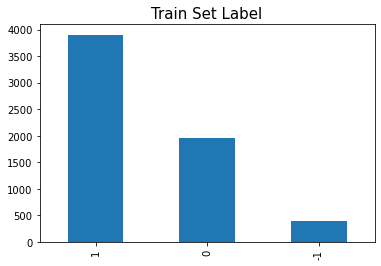

In [68]:
x_train['label'].value_counts().plot(kind='bar')
plt.title('Train Set Label', size = 15)
plt.show()

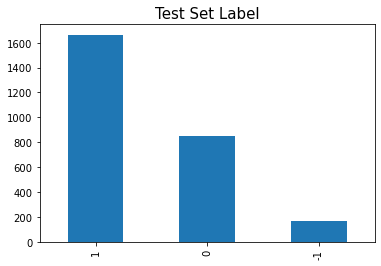

In [69]:
x_test['label'].value_counts().plot(kind='bar')
plt.title('Test Set Label', size = 15)
plt.show()

In [70]:
# Train_Set 레이블 현황 갯수
print('Train_Set  긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_train[x_train['label'].isin([1])]), len(x_train[x_train['label'].isin([0])]), len(x_train[x_train['label'].isin([-1])]), len(x_train)))
print()
# Test_Set 레이블 현황 갯수
print('Test_Set   긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_test[x_test['label'].isin([1])]), len(x_test[x_test['label'].isin([0])]), len(x_test[x_test['label'].isin([-1])]), len(x_test)))

Train_Set  긍정(1) : 3903 
	   중립(0) : 1960 
	   부정(-1) : 400 
	   총 합계 : 6263

Test_Set   긍정(1) : 1664 
	   중립(0) : 854 
	   부정(-1) : 167 
	   총 합계 : 2685


## Convert to two_dimensional list

In [71]:
print(len(x_train), len(x_test))

6263 2685


In [72]:
x_train

,nouns_title,label
0,열대야 일수 맞추다 우대금리 DGB 대구 은행 프리 적금,0
1,DGB 대구 은행 국가 고객 만족도 NCSI 지방 은행 1위 선정,1
2,금융 안전 비대 강화 포스 크다 코로나 에도 상품 개발 워드,1
3,DGB 캐피탈 협업 플로우 도입 목표 지향 업무 환경 강화,1
4,DGB 대구 은행 전세 대출 금리 인하 취급 제한 해제,1
...,...,...
6258,DGB 대구 은행 대구 미술관 지역 문화 발전 업무 협약 체결,1
6259,DGB 금융 그룹 봉사 통해 코로나 19 자가진단 키트 원금 전달,1
6260,DGB 대구 은행 우대금리 적용 DGB 삼일절 적금 판매,0
6261,상품 DGB 대구 은행 언택트 카드,0


In [73]:
x_test

,nouns_title,label
0,지방 은행 ESG DGB 금융 그룹 친환경 디지털로 ESG 경영 속도,1
1,경북 희망 2022 나눔 캠페인 출범 모금 목표 137억,1
2,더밸류 금융 신한은행 우리은행 DGB 대구 은행 AI 자산 관리 판교 금융 센터,0
3,DGB 금융 정보보호 실천 캠페인,1
4,DGB 대구 은행 캄보디아 현지 법인 상업 은행 공식 출범,1
...,...,...
2680,DGB 금융 ESG 경영 협의 열사 모이다 실천 방안 논의,1
2681,DGB 대구 은행 러시아 경제 제재 피해 기업 1000억원 금융 지원 상환 유예 제도,0
2682,대구 은행 BC 카드 온라인 간편 결제 할인 이벤트 3만원 결제 5000원 할인,1
2683,DGB 대구 은행 1090억 규모 중간배당 실시 모두 금융 지주 지급,1


In [74]:
# 리스트로 변환 후 체크 
# 6263
x_train_words = list()
for title_words in x_train['nouns_title']:
    x_train_words.append(list(title_words.split(' ')))

# 2685
x_test_words = list()
for title_words in x_test['nouns_title']:
    x_test_words.append(list(title_words.split(' ')))

In [75]:
print(x_train_words[:3])

[['열대야', '일수', '맞추다', '우대금리', 'DGB', '대구', '은행', '프리', '적금'], ['DGB', '대구', '은행', '국가', '고객', '만족도', 'NCSI', '지방', '은행', '1위', '선정'], ['금융', '안전', '비대', '강화', '포스', '크다', '코로나', '에도', '상품', '개발', '워드']]


In [76]:
print(x_test_words[:3])

[['지방', '은행', 'ESG', 'DGB', '금융', '그룹', '친환경', '디지털로', 'ESG', '경영', '속도'], ['경북', '희망', '2022', '나눔', '캠페인', '출범', '모금', '목표', '137억'], ['더밸류', '금융', '신한은행', '우리은행', 'DGB', '대구', '은행', 'AI', '자산', '관리', '판교', '금융', '센터']]


## Integer Encoding
- 토큰화 한 단어를 컴퓨터가 인식하도록 정수 인코딩 수행

In [77]:
from keras.preprocessing.text import Tokenizer

In [78]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_words)
tokenizer.fit_on_texts(x_test_words)

In [79]:
x_train_int = tokenizer.texts_to_sequences(x_train_words)

In [80]:
x_test_int = tokenizer.texts_to_sequences(x_test_words)

In [81]:
print(x_train_int[:3])

[[566, 667, 567, 219, 1, 3, 2, 337, 67], [1, 3, 2, 380, 24, 422, 1098, 11, 2, 226, 262], [4, 493, 20, 146, 3016, 547, 59, 478, 54, 108, 1465]]


In [82]:
print(x_test_int[:3])

[[11, 2, 19, 1, 4, 5, 103, 1976, 19, 22, 546], [17, 141, 99, 40, 66, 104, 1512, 494, 1184], [1773, 4, 811, 403, 1, 3, 2, 228, 252, 60, 4601, 4, 23]]


## 제목 길이 기준 분포 확인

제목의 최대 길이(단어의 수) : 15
제목의 평균 길이 : 9


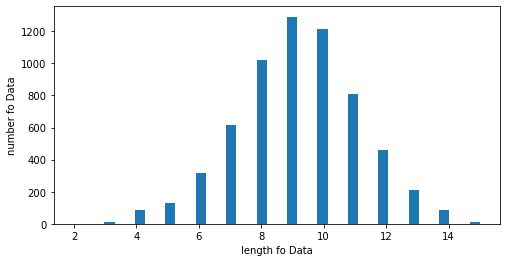

In [83]:
print('제목의 최대 길이(단어의 수) :', max([(len(i)) for i in x_train_int]))
print('제목의 평균 길이 :', sum([len(i) for i in x_train_int]) // len(x_train_int))
plt.figure(figsize = (8, 4))
plt.hist([len(i) for i in x_train_int], bins=40)
plt.xlabel('length fo Data')
plt.ylabel('number fo Data')
plt.show()

제목의 최대 길이(단어의 수) : 15
제목의 평균 길이 : 9


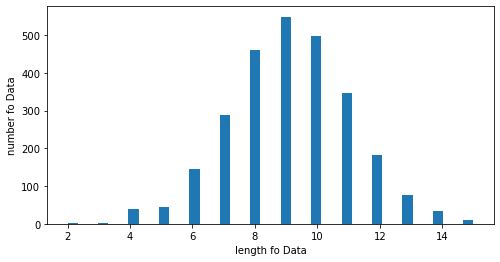

In [84]:
print('제목의 최대 길이(단어의 수) :', max([(len(i)) for i in x_test_int]))
print('제목의 평균 길이 :', sum([len(i) for i in x_test_int]) // len(x_test_int))
plt.figure(figsize = (8, 4))
plt.hist([len(i) for i in x_test_int], bins=40)
plt.xlabel('length fo Data')
plt.ylabel('number fo Data')
plt.show()

## Padding

- 길이를 길게 잡으면 학습 시간이 오래 걸림 --> 데이터 손실 최소화 + 효율성
- 데이터가 비교적 적은 부분은 패딩으로 처리하는게 좋음.
- maxlen의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일

**Ex) 길이가 5인 리스트가 있다면 5보다 작은 인덱스 값들은 0으로 패딩되고 5보다 큰 인덱스들은 즉, 6번째 인덱스부터는 데이터가 손실됨.**<br><br>
**참고<br> https://wikidocs.net/83544 (2/5 지점)<br>http://www.nextobe.com/2020/05/14/%EA%B0%80%EB%B3%80-%EA%B8%B8%EC%9D%B4-%EC%9E%85%EB%A0%A5-%EC%8B%9C%ED%80%80%EC%8A%A4%EC%97%90-%EB%8C%80%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A4%80%EB%B9%84/<br>https://sig413.tistory.com/5**

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [86]:
# 각 인덱스 길이대로 정렬
x_train_int.sort(key=lambda x:len(x),reverse = True)
x_test_int.sort(key=lambda x:len(x),reverse = True)

In [87]:
def limit_len(front, back, reset_list):
    cnt = 0
    for s in reset_list:
        # if (front <= len(s) <= back):
        if len(s) <= back:
            cnt += 1
    print('전체 학습 데이터 중 길이가 {} 이상 {} 이하인 비율 : {:.2f}%'.format(front, back,( cnt / len(x_train_int)) * 100))

In [88]:
# min_len = 4 / max_len = 14
# 앞선 제목의 평균 길이 그래프를 보면 ( 4 <= idx_num <= 14 ) 범위를 벗어난 인덱스들은 데이터가 현저히 적음.
limit_len(4, 14, x_train_int)

전체 학습 데이터 중 길이가 4 이상 14 이하인 비율 : 99.81%


**일단 14이하인 것만 패딩 --> 나중에 시간되면 4이상 14이하인 부분만 패딩하도록 전처리 필요**
<br>
**pad_sequences post / defalut로 각각 한번씩 해주면 됨.**

In [89]:
max_len = 14

In [90]:
x_train_final = pad_sequences(x_train_int, maxlen = max_len)

In [91]:
x_test_final = pad_sequences(x_test_int, maxlen = max_len)

## One-Hot-Encoding

- 단어 집합의 크기를 벡터로 변환하고, 표현하고 싶은 단어 인덱스에 1의 값 부여하고, 다른 인덱스는 0을 부여하는 단어의 벡터 표현 방식
- 즉, 1개만 Hot(True)이고 나머지는 Cold(False)

※ 벡터 (1차원)  /  행렬 (2차원)  /  배열 (3차원)  /  텐서 (3차원 이상)
<br>
<br>
**참고 : https://godcode.tistory.com/9?category=908926**

In [92]:
tokenizer.word_index

{'dgb': 1,
 '은행': 2,
 '대구': 3,
 '금융': 4,
 '그룹': 5,
 '대출': 6,
 '지원': 7,
 '지역': 8,
 '버스': 9,
 '메타': 10,
 '지방': 11,
 '실시': 12,
 '개최': 13,
 '전달': 14,
 '기업': 15,
 '사랑': 16,
 '경북': 17,
 '투자': 18,
 'esg': 19,
 '비대': 20,
 '협약': 21,
 '경영': 22,
 '센터': 23,
 '고객': 24,
 '업무': 25,
 '서비스': 26,
 '김태오': 27,
 '최대': 28,
 '채용': 29,
 '증권': 30,
 '카드': 31,
 '디지털': 32,
 '회장': 33,
 '출시': 34,
 '모집': 35,
 '이벤트': 36,
 '전문': 37,
 '특별': 38,
 '캄보디아': 39,
 '나눔': 40,
 '신용': 41,
 '금리': 42,
 '역대': 43,
 '직원': 44,
 '점포': 45,
 '자금': 46,
 '실적': 47,
 '하이': 48,
 '피해': 49,
 '오픈': 50,
 '주년': 51,
 '기념': 52,
 '순이익': 53,
 '상품': 54,
 '지주': 55,
 '2021': 56,
 '임성훈': 57,
 '실천': 58,
 '코로나': 59,
 '관리': 60,
 '복합': 61,
 '공인': 62,
 '산업': 63,
 '상반기': 64,
 '은행권': 65,
 '캠페인': 66,
 '적금': 67,
 'im': 68,
 '행사': 69,
 '맞다': 70,
 '확대': 71,
 '인사': 72,
 '창립': 73,
 '독도': 74,
 '체결': 75,
 '소상': 76,
 '전세': 77,
 '대다': 78,
 '주택': 79,
 '진행': 80,
 '계층': 81,
 '뱅크': 82,
 '종합': 83,
 '신입': 84,
 '할인': 85,
 '페이': 86,
 '까지': 87,
 '산불': 88,
 '플랫폼': 89,
 '전국': 90,
 '

In [93]:
import numpy as np

y_train = list()
y_test = list()
x_train['label'].unique().tolist()

[0, 1, -1]

In [94]:
# 1 / 0 / -1
def one_hot_encoding(label):
    one_hot_vector = [0] * len(x_train['label'].unique().tolist())
    one_hot_vector[label+1] = 1
    return one_hot_vector

In [95]:
def right_answer():
    for tr in x_train['label']:
        y_train.append(one_hot_encoding(tr))
    for te in x_test['label']:
        y_test.append(one_hot_encoding(te))

right_answer()

In [96]:
if (len(y_train) + len(y_test)) == len(df_news_copy['label']):
    print('정상')
else:
    y_train = list()
    y_test = list()
    right_answer()
    print('재확인 필요')

정상


In [97]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [98]:
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [99]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [100]:
len(y_test) + len(y_train)

8948

In [101]:
len(x_test_final) + len(x_train_final)

8948

## 빈도 수가 낮은 단어 제거 --> 대기
- 빈도수가 낮은 단어 --> 학습에 영향이 크지 않음.
- 전처리를 통해 제거
- 패딩 --> 학습 시간 단축 및 최적의 효율성

**한두번 나온 단어가 그 문장의 감성을 표현할 수 있는 핵심단어 일수도?**

In [102]:
len(tokenizer.word_counts)

5289

In [103]:
threshold = 2 # 임계치
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
print('단어 집합(vocabulary)의 종류 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {:.2f}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / words_freq) * 100)

단어 집합(vocabulary)의 종류 : 5289
등장 빈도가 1번 이하인 희귀 단어의 수: 2274
단어 집합에서 희귀 단어의 비율: 42.99
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7635992416508675


In [104]:
vocab_size = total_cnt-rare_cnt
print(vocab_size)

3015


In [105]:
# 대기

In [106]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')

In [107]:
tokenizer

# 모델링

- 성능 높이기 + 시각화 해서 파일로 만들기

## GPU 체크
- NVIDIA GeForce RTX 2070 SUPER : 2개 (GPU index number : 0, 1)
- CPU :1 개 ( CPU index number : 0)

In [131]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [132]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## 데이터셋 확인

In [133]:
from keras import models
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Input, LSTM, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model

%matplotlib inline
# Function call stack:
# train_function -> train_function -> train_function
# 해당 줄로 오류 해결
# 참고 : https://www.freesion.com/article/71721347190/
tf.compat.v1.disable_eager_execution()

In [134]:
print('x_train :', x_train_final.shape)
print('x_test :', x_test_final.shape)
print('y_train :', y_train.shape)
print('x_test :', y_test.shape)

x_train : (6263, 14)
x_test : (2685, 14)
y_train : (6263, 3)
x_test : (2685, 3)


## optimizers 정의 및 튜닝 ( Adam, SGD, RMSprop)

- 하이퍼 파라미터 튜닝

**val_loss 감소시키는 방법 : https://lsjsj92.tistory.com/353**

In [172]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.001, epsilon=None, amsgrad=False)

sgd = SGD(learning_rate=0.001, momentum=0.9, decay=0.0001, nesterov=False)

rmsprop = RMSprop(learning_rate=0.001, rho=0.9, decay=0.0001, epsilon=None)

### LSTM 1 Layer

In [147]:
model_01 = Sequential() # tensorflow.keras.models

In [148]:
# https://catwolf.org/qs?id=8ed4be3f-40bc-4351-829e-ad78e10aa3ad&x=y
# https://stackoverflow.com/questions/56598749/input-shape-in-keras-this-loss-expects-targets-to-have-the-same-shape-as-the-ou

model_01.add(Embedding(total_cnt, 100))
# model_01.add(LSTM(128, activation = 'tanh', return_sequences=False))
model_01.add(LSTM(128, return_sequences=False))
model_01.add(Dropout(0.2))
model_01.add(Dense(3, activation='softmax'))
model_01.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         528900    
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 646,535
Trainable params: 646,535
Non-trainable params: 0
_________________________________________________________________


In [149]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=30)
mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=5, save_best_only=True)

model_01.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
history = model_01.fit(x_train_final, y_train, epochs=60, callbacks=[es], batch_size=512, validation_split=0.2)

Train on 5010 samples, validate on 1253 samples
Epoch 1/30
5010/5010 [==============================] - 5s 1ms/sample - loss: 0.1716 - accuracy: 0.6250 - val_loss: 0.1781 - val_accuracy: 0.6073
Epoch 2/30
5010/5010 [==============================] - 5s 907us/sample - loss: 0.1660 - accuracy: 0.6281 - val_loss: 0.1804 - val_accuracy: 0.6073
Epoch 3/30
5010/5010 [==============================] - 5s 916us/sample - loss: 0.1578 - accuracy: 0.6433 - val_loss: 0.1839 - val_accuracy: 0.5714
Epoch 4/30
5010/5010 [==============================] - 5s 906us/sample - loss: 0.1490 - accuracy: 0.6629 - val_loss: 0.2012 - val_accuracy: 0.4733
Epoch 5/30
 480/5010 [=>............................] - ETA: 3s - loss: 0.1363 - accuracy: 0.6917

KeyboardInterrupt: 

## LSTM / Dropout / GRU / Dropout 4 Layer

In [230]:
model_02 = Sequential() # tensorflow.keras.models

In [221]:
# model_02.add(Embedding(total_cnt, 100))
# model_02.add(LSTM(128, return_sequences=True))
# model_02.add(Dropout(0.5))
# model_02.add(GRU(128))
# model_02.add(Dropout(0.5))
# model_02.add(Dense(3, activation='softmax'))

In [231]:
# https://catwolf.org/qs?id=8ed4be3f-40bc-4351-829e-ad78e10aa3ad&x=y
# https://stackoverflow.com/questions/56598749/input-shape-in-keras-this-loss-expects-targets-to-have-the-same-shape-as-the-ou

model_02.add(Embedding(total_cnt, 100))

model_02.add(LSTM(32, activation = 'tanh',return_sequences=True))
model_02.add(Dropout(0.5))

model_02.add(LSTM(64, return_sequences=True))
model_02.add(Dropout(0.4))

model_02.add(LSTM(128,return_sequences=True))
model_02.add(Dropout(0.5))

model_02.add(LSTM(256,return_sequences=True))
model_02.add(Dropout(0.4))

model_02.add(GRU(512))

# model_02.add(Dense(1028, activation='relu'))
model_02.add(Dense(3, activation='softmax'))
         
model_02.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, None, 100)         528900    
_________________________________________________________________
lstm_62 (LSTM)               (None, None, 32)          17024     
_________________________________________________________________
dropout_56 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_63 (LSTM)               (None, None, 64)          24832     
_________________________________________________________________
dropout_57 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
dropout_58 (Dropout)         (None, None, 128)       

In [228]:
tf.config.set_soft_device_placement(True)

In [232]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=30)
mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=5, save_best_only=True)
model_02.compile(optimizer= adam, loss='mse', metrics=['accuracy'])

history = model_02.fit(x_train_final, y_train, epochs=250, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Train on 5010 samples, validate on 1253 samples
Epoch 1/250
5010/5010 [==============================] - 15s 3ms/sample - loss: 0.1734 - accuracy: 0.6202 - val_loss: 0.1762 - val_accuracy: 0.6073
Epoch 2/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.1691 - accuracy: 0.6271 - val_loss: 0.1806 - val_accuracy: 0.6073
Epoch 3/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.1671 - accuracy: 0.6269 - val_loss: 0.1779 - val_accuracy: 0.6073
Epoch 4/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.1571 - accuracy: 0.6471 - val_loss: 0.1804 - val_accuracy: 0.6010
Epoch 5/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.1447 - accuracy: 0.6814 - val_loss: 0.1836 - val_accuracy: 0.5954
Epoch 6/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.1374 - accuracy: 0.6986 - val_loss: 0.1857 - val_accuracy: 0.5882
Epoch 7/250
5010/5010 [==============================] - 10s 2ms

5010/5010 [==============================] - 10s 2ms/sample - loss: 0.0914 - accuracy: 0.8070 - val_loss: 0.2203 - val_accuracy: 0.5419
Epoch 28/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.0905 - accuracy: 0.8080 - val_loss: 0.2221 - val_accuracy: 0.5411
Epoch 29/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.0896 - accuracy: 0.8122 - val_loss: 0.2222 - val_accuracy: 0.5435
Epoch 30/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.0887 - accuracy: 0.8112 - val_loss: 0.2325 - val_accuracy: 0.5156
Epoch 31/250
5010/5010 [==============================] - 10s 2ms/sample - loss: 0.0886 - accuracy: 0.8134 - val_loss: 0.2238 - val_accuracy: 0.5515
Epoch 00031: early stopping


In [ ]:
model.evaluate(x_test_final, y_test)[1] * 100

In [ ]:
predict = model.predict(x_test_final)

In [ ]:
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)

In [ ]:
predict_labels[:5]

In [ ]:
for i in range(50):
    print('기사 제목  :', x_test['nouns_title'].iloc[i], '/\t 원래 라벨 :', original_labels[i], '/\t 예측한 라벨 :', predict_labels[i])

In [ ]:
model = Sequential()
model.add(Embedding(total_cnt, 100))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(x_train_final, y_train, epochs=15, callbacks=[es, mc], batch_size=6000, validation_split=0.2)

## 제목 길이 기준 분포 확인

# 그래프 분석 (EDA)
<br>

**언론사별 / 월별 / 주중별기사 수량 확인**
    
    ▶ 언론사를 각 숫자로 표현 후 EDA 실시 Ex) 1 : 미디어펜, 2 : 아이뉴스24, 3 : 데일리안 ...
    ▶ date : 등록된 기사별 날짜
**아직 제대로 진행 안됨...**

In [ ]:
# 날짜별 데이터 갯수
df_news_copy.groupby('date').count().head(3)

## 월별 기사 갯수
<br>

**참고사이트 : https://zephyrus1111.tistory.com/9**

In [ ]:
df_news_copy.describe(include='all')

In [ ]:
# 시각화 글자 깨짐 방지
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [ ]:
df_news.head()

In [ ]:
df_news.hist(figsize = (16, 12))
plt.show()

In [ ]:
# 2021년도부터 시작
def next_date_get(x):
    year = 21
    for i in range(len(x)):
        if (x[i] % 12) != 0:
            if x[i] < 10:
                x.insert(i, '{}.0'.format(str(year)) + str(x.pop(i)))
            else:
                x.insert(i, '{}.'.format(str(year)) + str(x.pop(i)))
        else:
            x.insert(i, '{}.'.format(str(year)) + str(x.pop(i))) # 12월까지 카운트
            year += 1 # 다음년도
    return x

# 월별로 정렬이 되어 있으므로 21 ~ 22년도 사이 지정 해주어야 함.
x = next_date_get(df_news_copy['month'].unique().tolist()) 

tmp_a, tmp_b = df_news_copy.groupby('month')['date'].count().tolist()[4:], df_news_copy.groupby('month')['date'].count().tolist()[:4]
y = tmp_a + tmp_b

print('2021.05 ~ :', x) # 월
print('2021.05 ~ :', y) # 값

In [ ]:
plt.figure(figsize = (16, 8))

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='green',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title('월별 뉴스 기사', size = 25)
plt.bar(x, y, width=0.5, color='pink')
plt.xlabel('월별', size = 20, labelpad=20) # x축 제목 설정
plt.ylabel('갯수', size = 20, labelpad=20) #y축 제목 설정, 빨간 글씨
plt.show()

## 언론사별 기사 갯수
- 언론사별 범주형 데이터 --> 수치형으로 변환

In [ ]:
df_news.head(1)

In [ ]:
len(df_news['press'].unique())
df_news['press'].unique()[:5]

In [ ]:
df_news_copy['press'].unique()
x = df_news_copy['press'].value_counts().index.tolist()
y = df_news_copy['press'].value_counts().values.tolist()

In [ ]:
# 기사 갯수가 85 이상인 것만
limit = 0
for idx, value  in enumerate(y):
    if value < 85:
        limit = idx
        break

x = x[:limit]
y = y[:limit]

In [ ]:
df_news_copy['press'].value_counts()[50:]

In [ ]:
plt.figure(figsize = (46, 12))

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='green',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title('언론사별 기사 개수', fontsize = 20)
plt.bar(x, y, width=0.5, color = 'pink')
plt.xticks(rotation = -45)
plt.xlabel('count', fontsize=20)
plt.ylabel('press', fontsize=20)
plt.show()

# 해야할 것들
- 이슈분석지표 워드 클라우드는 이제 단어별 갯수 구한 후 표 그리면 완성
- 감정분석 
<br><br>
- 1. 현재 사용중인 CSV파일이 아닌 1년치 데이터를 스크래핑
<br><br>
- 2. 스크래핑한 데이터의 갯수가 50000개의 데이터라면 / Train_set : 70% Test_set : 30%로 분할 (랜덤모듈이용)<br>
※ 단, Test_set 분할시 2.5%로 12개월분할하면 제일 좋음 ( 매달마다 2.5%의 Test_set를 뽑아와서 총 30%로 만듬.) 1~12월 골고루 뽑아올 수 있음.
<br><br>
- 3. Train_set에 Labeling을 해주어야 함. (긍정 1, 부정 -1, 중립 0)
<br>
※ Labeling 할 때 어떤식으로 정답을 부여할지 생각해야 됨.
<br>
<br>
- 4. 코로나 이전 1년치랑 이후 1년치 데이터 비교
<br>
1. 긍정 부정 단어사전 구축 후 레이블링 작업 진행
